In [ ]:
# # Install Pycocotools
# !pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# # Install detectron 2
# !python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html

# Install detectron from git because pip version doesnt work
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-yany6t17
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-yany6t17
  Resolved https://github.com/facebookresearch/fvcore.git to commit 51092b5515cbb493f73de079743dd6b11cc4bbf1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.6-py3-none-any.whl size=65405 sha256=ef3e7b75f6a5a962862c44ff007b33d0c991bf3c827d462bf7b1f282a0562203
  Stored in directory: /tmp/pip-ephem-wheel-cache-vmlnepem/wheels/8f/cb/6a/3b7ac0e01781855ca3d1417ebf9e15e20d5b7fe37ab063aa50
  Created wheel for iopath: filename=

In [ ]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
pylab.rcParams['figure.figsize'] = (8.0, 10.0)# Import Libraries

# For visualization
import os
import seaborn as sns
from matplotlib import colors
from tensorboard.backend.event_processing import event_accumulator as ea
from PIL import Image

# Scipy for calculating distance
from scipy.spatial import distance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import skimage.io as io

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Set base params
plt.rcParams["figure.figsize"] = [16,9]

In [ ]:
#get configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (damage) + 1
cfg.MODEL.RETINANET.NUM_CLASSES = 1 # only has one class (damage) + 1
cfg.MODEL.WEIGHTS = os.path.join("/content/drive/MyDrive/models/damage_segmentation_model_v5.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
cfg['MODEL']['DEVICE']='cpu'#or cuda
damage_predictor = DefaultPredictor(cfg)

[05/06 19:48:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/models/damage_segmentation_model_v5.pth ...


In [ ]:
cfg_mul = get_cfg()
cfg_mul.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_mul.MODEL.ROI_HEADS.NUM_CLASSES = 5  # only has five classes (headlamp,hood,rear_bumper,front_bumper_door) + 1
cfg_mul.MODEL.RETINANET.NUM_CLASSES = 5 # only has five classes (headlamp,hood,rear_bumper,front_bumper_door) + 1
cfg_mul.MODEL.WEIGHTS = os.path.join("/content/drive/MyDrive/models/part_segmentation_model.pth")
cfg_mul.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
cfg_mul['MODEL']['DEVICE']='cpu' #or cuda
part_predictor = DefaultPredictor(cfg_mul)

[05/06 19:49:39 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/models/part_segmentation_model.pth ...


In [ ]:

damage_class_map= {0:'damage'}
parts_class_map={0:'headlamp',1:'rear_bumper', 2:'door', 3:'hood', 4: 'front_bumper'}

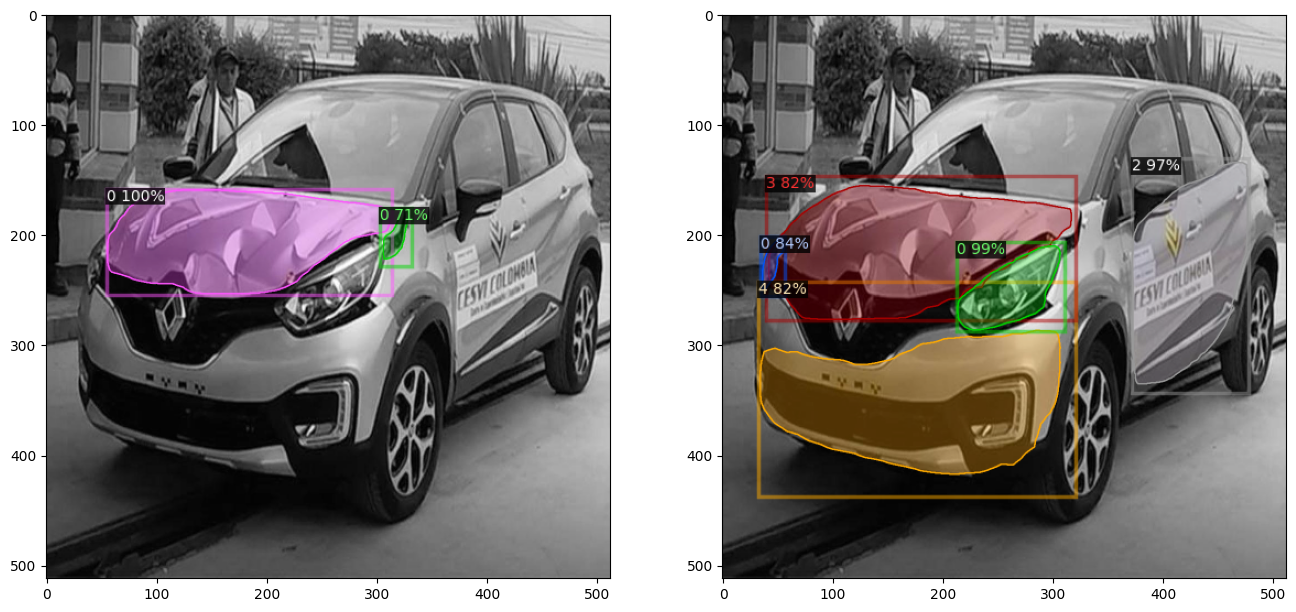

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(16,12))
im = io.imread("/content/drive/MyDrive/images/img/56.jpg")

#damage inference
damage_outputs = damage_predictor(im)
damage_v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("car_dataset_val"), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
damage_out = damage_v.draw_instance_predictions(damage_outputs["instances"].to("cpu"))

#part inference
parts_outputs = part_predictor(im)
parts_v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("car_mul_dataset_val"), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
parts_out = parts_v.draw_instance_predictions(parts_outputs["instances"].to("cpu"))

#plot
ax1.imshow(damage_out.get_image()[:, :, ::-1],)
ax2.imshow(parts_out.get_image()[:, :, ::-1])

In [ ]:
damage_prediction_classes = [ damage_class_map[el] + "_" + str(indx) for indx,el in enumerate(damage_outputs["instances"].pred_classes.tolist())]
print(damage_outputs["instances"].pred_boxes.get_centers().tolist(), damage_outputs["instances"].pred_boxes)
damage_polygon_centers = damage_outputs["instances"].pred_boxes
damage_dict = dict(zip(damage_prediction_classes,damage_polygon_centers))
parts_prediction_classes = [ parts_class_map[el] + "_" + str(indx) for indx,el in enumerate(parts_outputs["instances"].pred_classes.tolist())]
parts_polygon_centers =  parts_outputs["instances"].pred_boxes



#Remove centers which lie in beyond 800 units
parts_polygon_centers_filtered = list(filter(lambda x: x[0] < 800 and x[1] < 800, parts_polygon_centers))
parts_dict = dict(zip(parts_prediction_classes,parts_polygon_centers_filtered))

[[368.81640625, 413.22979736328125], [635.1226806640625, 404.6199951171875]] Boxes(tensor([[109.6909, 317.0541, 627.9420, 509.4055],
        [605.7449, 351.2323, 664.5004, 458.0077]]))


######################### DAMAGES #########################

Part                              Area
-----------------------------------------------------------------
hood                                99686.27766064368
hood                                6273.637147806585

######################### COST ESTIMATION #########################

Part                              Replace/Fix          Cost (Rs)          Damaged Area
-----------------------------------------------------------------
hood                                Replace             40000
-----------------------------------------------------------------
TOTAL DETECTED ESTIMATED COST                           40000

#################################################################
Not detected:  []


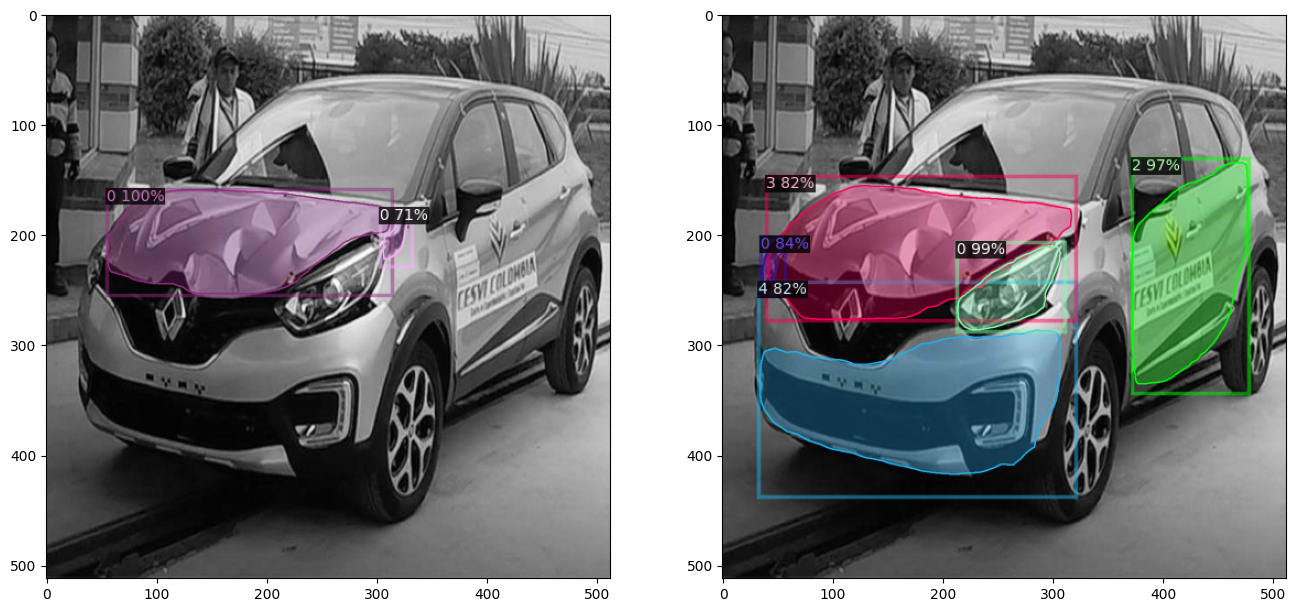

In [ ]:
def get_centers(point):
  return [(point[0] + point[2]) / 2, (point[1] + point[3]) / 2 ]

def get_area(point):
  return abs(point[2] - point[0]) * abs(point[3] - point[1])

def detect_damage_part(damage_dict, parts_dict):
  """
  Returns the most plausible damaged part for the list of damages by checking the distance 
  between centers centers of damage_polygons and parts_polygons

  Parameters
  -------------
   damage_dict: dict
                Dictionary that maps damages to damage polygon centers.
   parts_dict: dict
                Dictionary that maps part labels to parts polygon centers.
  Return
  ----------
  part_name: str
            The most plausible damaged part name.
  """
  not_identified_damages = []
  try:
    max_distance = 10e9
    assert len(damage_dict)>0, "AssertError: damage_dict should have atleast one damage"
    assert len(parts_dict)>0, "AssertError: parts_dict should have atleast one part"
    max_distance_dict = dict(zip(damage_dict.keys(),[max_distance]*len(damage_dict)))
    part_name = dict(zip(damage_dict.keys(),['']*len(damage_dict)))

    
    for y in parts_dict.keys():
        for x in damage_dict.keys():
          # print(damage_dict[x].tolist(), parts_dict[y])
          dis = distance.euclidean(get_centers(damage_dict[x].tolist()), get_centers(parts_dict[y].tolist()))
          if dis < max_distance_dict[x]:
           
            part_name[x] = [y.rsplit('_',1)[0], get_area(damage_dict[x].tolist())]
          else:
            not_identified_damages.append([x,y])
    return list(part_name.values()), not_identified_damages

    
  except Exception as e:
    print(e)
    return [], []

REAL_WIDTH_IN_CM = 150
CAR_MODEL = 'toyota'

REPLACE_IF_AREA_GREATER_THAN = {
    'door': 2000,
    'headlamp': 0,
    'rear_bumper': 1000,
    'hood': 1500,
    'front_bumper': 3000
}


def should_replace(item):
  return item[1] > REPLACE_IF_AREA_GREATER_THAN[item[0]]


COST_DICTIONARY = {'toyota': {
    'door': {'replace': 10000, 'fix': 100},
    'headlamp': {'replace': 20000},
    'rear_bumper': {'replace': 30000, 'fix': 200 },
    'hood': {'replace': 40000, 'fix': 300},
    'front_bumper': {'replace': 15000, 'fix': 150 }}
}

def calculate_cost(item):
  if(should_replace(item)):
    r_or_f = 'replace' 
    return (COST_DICTIONARY[CAR_MODEL][item[0]]['replace'])
  else:
    r_or_f = "fix"
    return (COST_DICTIONARY[CAR_MODEL][item[0]]['fix'] * item[1])
  
identified, not_identified = detect_damage_part(damage_dict,parts_dict)


total_cost = 0
rows = []

print("#"*25 + " DAMAGES " + "#"*25 )
print()
print("Part" + " " * 30 + "Area")
print("-" * 65)
for item in identified:
  # print(item)
  if(should_replace(item)):
    r_or_f = 'Replace' 
  else:
    r_or_f = "Fix"
  cost = calculate_cost(item)
  rows.append([item[0],r_or_f,cost,item[1]])
  print(item[0], " " * (30 - len(item[0]) + 4) , item[1])

print()

print("#"*25 + " COST ESTIMATION " + "#"*25 )
print("")
print("Part" + " " * 30 + "Replace/Fix" + " " * 10 + "Cost (Rs)" + " " * 10 + "Damaged Area")
print("-" * 65)


# Items to be fixed
for row in rows:
  if(row[0] not in [x[0] for x in rows if x[1] == 'Replace']):
    total_cost += row[2]
    print(row[0], " " * (30 - len(row[0]) + 4) , row[1] + " " * (10 - len(row[1]) + 9) , str(row[2]), " " * 10 + str(row[3]) )

# Items to be replaced
for item in list(set([x[0] for x in rows if x[1] == 'Replace'])):
  row = [x for x in rows if x[1] == 'Replace' and x[0] == item][0]
  total_cost += row[2]
  print(row[0], " " * (30 - len(row[0]) + 4) , row[1] + " " * (10 - len(row[1]) + 9) , str(row[2]))

print("-" * 65)
print("TOTAL DETECTED ESTIMATED COST", " " * int((40 - len("TOTAL DETECTED ESTIMATED COST") + 14)/1), str(total_cost))
print()
print("#" * 65)
# print("Damaged Parts: ",identified)
print("Not detected: ", not_identified)

#plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(16,12))
ax1.imshow(damage_out.get_image()[:, :, ::-1],)
ax2.imshow(parts_out.get_image()[:, :, ::-1])